In [1]:
%load_ext autoreload
%autoreload 2

In [117]:
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import GrayscaleObservation, ResizeObservation, RecordEpisodeStatistics, RecordVideo, TimeLimit
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
import os
import gc
from eval import *
from custom_cr import EnhancedCarRacing
import pandas as pd
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.atari_wrappers import WarpFrame
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecTransposeImage
from stable_baselines3.common.vec_env import VecNormalize

### 3.1. Task Specific Metrics

#### 3.1.1. Baseline DQN

In [32]:
# Load the evaluations.npz file
evaluations = np.load("models/baseline/DQN/evaluations.npz")

# List the available keys
print(f"Keys in evaluations.npz: {evaluations.files}")

# Extract relevant data
timesteps_baseline_dqn = evaluations['timesteps']/8  # Training steps
results_baseline_dqn = evaluations['results'] # Mean rewards (or similar metrics)
ep_lengths_baseline_dqn = evaluations['ep_lengths']  # Episode lengths


Keys in evaluations.npz: ['timesteps', 'results', 'ep_lengths']


#### 3.1.2. Baseline PPO

In [ ]:
# Load the evaluations.npz file
evaluations = np.load("models/baseline/PPO/evaluations.npz")

# List the available keys
print(f"Keys in evaluations.npz: {evaluations.files}")

# Extract relevant data
timesteps_baseline_ppo = evaluations['timesteps']  # Training steps
results_baseline_ppo = evaluations['results'] # Mean rewards (or similar metrics)
ep_lengths_baseline_ppo = evaluations['ep_lengths']  # Episode lengths


Keys in evaluations.npz: ['timesteps', 'results', 'ep_lengths']


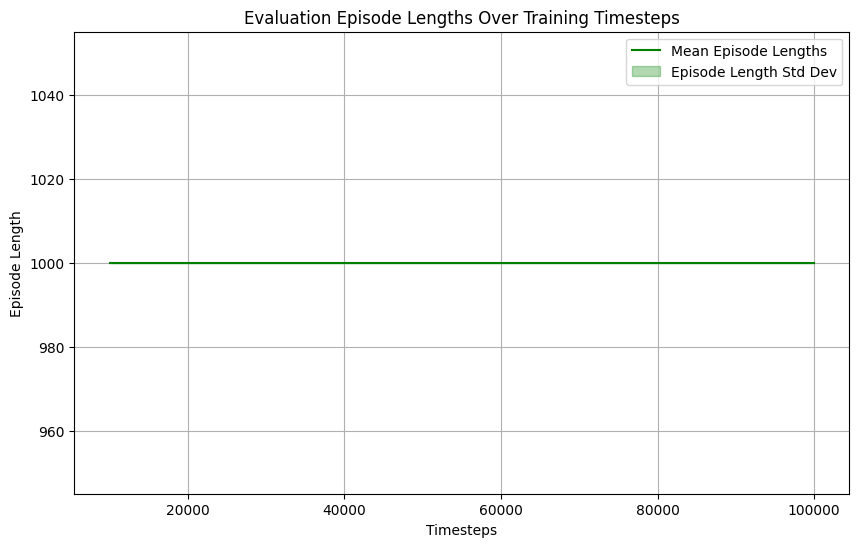

In [145]:
plot_episode_lengths(timesteps_baseline_ppo, ep_lengths_baseline_ppo)

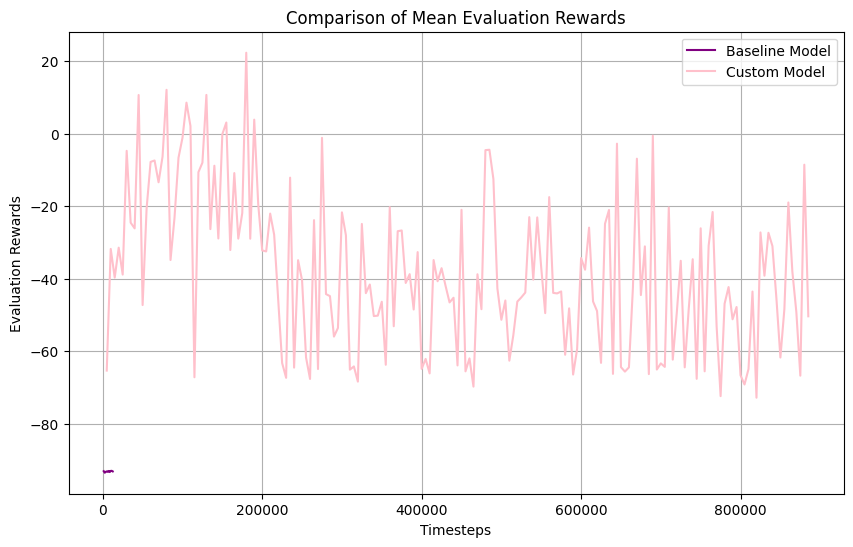

In [349]:
compare_rewards(timesteps_baseline_ppo, timesteps_baseline_dqn, results_baseline_ppo, results_baseline_dqn)

#### 3.1.3. Customized DQN

In [31]:
# Load the evaluations.npz file
evaluations = np.load("models/custom/DQN/evaluations.npz")

# List the available keys
print(f"Keys in evaluations.npz: {evaluations.files}")

# Extract relevant data
timesteps_custom_dqn = evaluations['timesteps']  # Training steps
results_custom_dqn = evaluations['results']  # Mean rewards (or similar metrics)
ep_lengths_custom_dqn = evaluations['ep_lengths']  # Episode lengths


Keys in evaluations.npz: ['timesteps', 'results', 'ep_lengths']


#### 3.1.4. Customized PPO

In [105]:
# Load the evaluations.npz file
evaluations = np.load("models/custom/PPO/evaluations.npz")

# List the available keys
print(f"Keys in evaluations.npz: {evaluations.files}")

# Extract relevant data
timesteps_custom_ppo = evaluations['timesteps'] / 10  # Training steps
results_custom_ppo = evaluations['results']  # Mean rewards (or similar metrics)
ep_lengths_custom_ppo = evaluations['ep_lengths']  # Episode lengths


Keys in evaluations.npz: ['timesteps', 'results', 'ep_lengths']


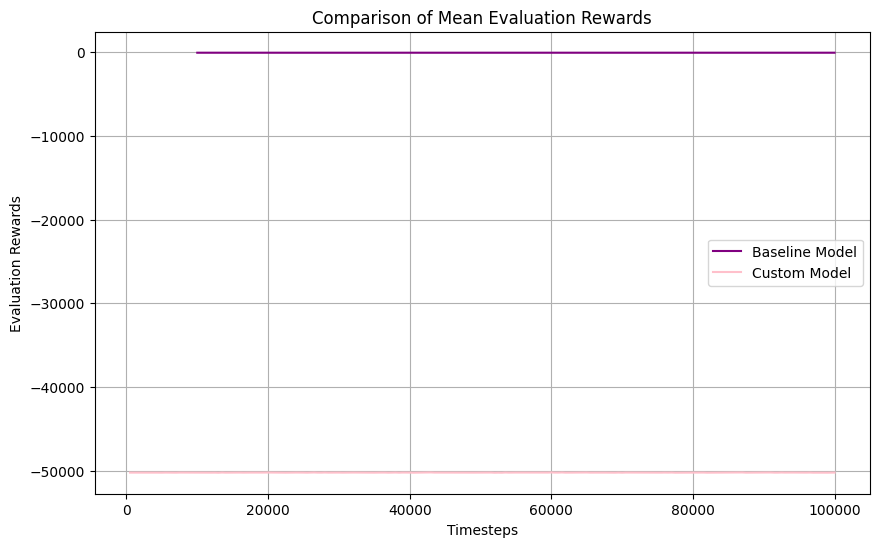

In [106]:
compare_rewards(timesteps_baseline_ppo, timesteps_custom_ppo, results_baseline_ppo, results_custom_ppo)

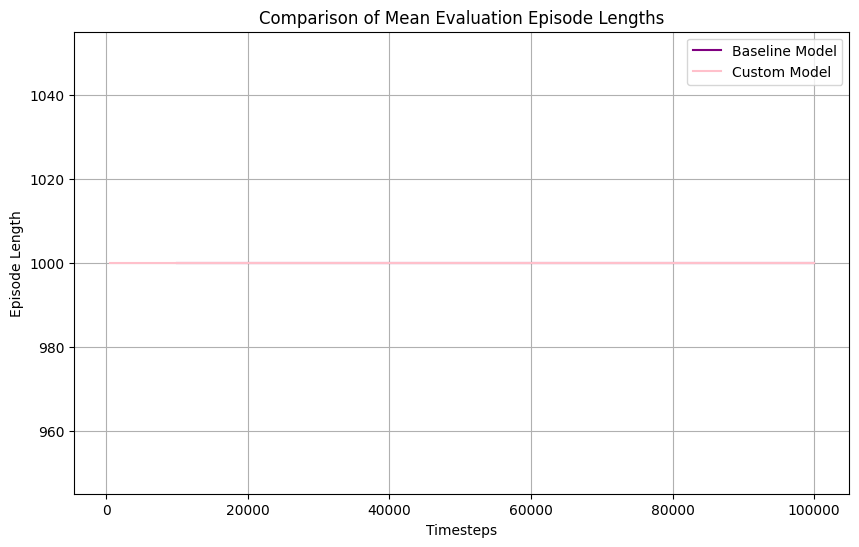

In [108]:
compare_episode_lengths(timesteps_baseline_ppo, timesteps_custom_ppo, ep_lengths_baseline_ppo, ep_lengths_custom_ppo)

### 3.2. Robustness and Adaptability

1. Robustness to Observation Noise:
   - It runs `num_episodes` episodes with added Gaussian noise to the observations.
   - For each step, it adds noise to the observation before predicting an action.
   - It accumulates the total reward for each episode and stores it in `noise_rewards`.

2. Robustness to Environment Perturbations:
   - It runs another set of episodes, this time applying random perturbations to the environment.
   - With probability `perturbation_prob`, it adds uniform random noise to the observation.
   - It accumulates the total reward for each episode and stores it in `perturbation_rewards`.

3. Results Computation and Output:
   - For each robustness scenario, it calculates and prints the mean and standard deviation of the rewards.
   
This function is designed to evaluate how well the trained model performs under different types of perturbations and variations, which is crucial for assessing the robustness and generalization capabilities of the reinforcement learning agent.

#### 3.2.1 Baseline - DQN

In [ ]:
best_model_baseline_dqn = DQN.load('./models/baseline/DQN/best_model.zip', allow_pickle=True)

In [42]:
env = gym.make("CarRacing-v3", continuous=False)

In [ ]:
robustness_results_baseline_dqn = evaluate_robustness(best_model_baseline_dqn, env, num_episodes=10)

In [114]:
robustness_results_baseline_dqn.to_csv('results/robustness_results_baseline_dqn.csv', index=False)
robustness_results_baseline_dqn = pd.read_csv('results/robustness_results_baseline_dqn.csv')
robustness_results_baseline_dqn

,noise_rewards,perturbation_rewards
0,904.3,907.2
1,904.2,813.8
2,906.3,910.9
3,918.2,908.8
4,911.0,811.3
5,904.2,830.2
6,899.3,902.3
7,897.6,901.8
8,907.8,815.1
9,902.7,906.9


#### 3.2.2 Baseline - PPO

In [212]:
env = gym.make("CarRacing-v3", continuous=False)

In [133]:
best_model_baseline_ppo = PPO.load('./models/baseline/PPO/best_model.zip')

In [ ]:
robustness_results_baseline_ppo = evaluate_robustness(best_model_baseline_ppo, env, num_episodes=1)

In [209]:
robustness_results_baseline_ppo.to_csv('results/robustness_results_baseline_ppo.csv', index=False)

In [210]:
robustness_results_baseline_ppo = pd.read_csv('results/robustness_results_baseline_ppo.csv')
robustness_results_baseline_ppo

,noise_rewards,perturbation_rewards
0,-92.856300,-93.709830
1,-93.030510,-93.287740
2,-93.173210,-93.265144
3,-93.526650,-93.441770
4,-93.078735,-92.906950
5,-92.031040,-92.673150
6,-93.054710,-93.670030
7,-93.287740,-94.168236
8,-93.526650,-93.006140
9,-93.149830,-93.054710


#### 3.2.3 Custom Environment - DQN

In [272]:
custom_env = EnhancedCarRacing(render_mode="rgb_array")
custom_env = GrayscaleObservation(custom_env, keep_dim=True)

In [273]:
best_model_custom_dqn = DQN.load('./models/custom/DQN/best_model.zip', allow_pickle=True)

In [ ]:
robustness_results_custom_dqn = evaluate_robustness(best_model_custom_dqn, custom_env, num_episodes=10)

In [282]:
robustness_results_custom_dqn.to_csv('results/robustness_results_custom_dqn.csv', index=False)

In [283]:
robustness_results_custom_dqn = pd.read_csv('results/robustness_results_custom_dqn.csv')
robustness_results_custom_dqn

,noise_rewards,perturbation_rewards
0,-7771.357178,-8028.335492
1,-8143.257228,-4435.307902
2,-7734.007272,-8074.779466
3,-3810.636480,-4780.440183
4,-7537.620328,-4700.406524
5,-7860.230395,-8170.175404
6,-7623.685771,-7632.930530
7,-3578.492066,-7615.139320
8,-6910.974139,-7828.289032
9,-6876.831676,-8111.588311


#### 3.2.4 Custom Environment - PPO

In [302]:
custom_env = EnhancedCarRacing(render_mode="rgb_array")
custom_env = GrayscaleObservation(custom_env, keep_dim=True)
custom_env = TimeLimit(custom_env, max_episode_steps=250)

In [ ]:
best_model_custom_ppo = PPO.load('./models/custom/PPO/best_model.zip', allow_pickle=True)

In [ ]:
robustness_results_custom_ppo = evaluate_robustness(best_model_custom_ppo, custom_env, num_episodes=10)

In [345]:
robustness_results_custom_ppo.to_csv('results/robustness_results_custom_ppo.csv', index=False)

In [346]:
robustness_results_custom_ppo = pd.read_csv('results/robustness_results_custom_ppo.csv')
robustness_results_custom_ppo

,noise_rewards,perturbation_rewards
0,-3174.935952,0.0
1,-3169.360647,0.0
2,-3167.753479,0.0
3,-3171.770366,0.0
4,-3167.930271,0.0
5,-3174.894345,0.0
6,-3179.042609,0.0
7,-3164.992426,0.0
8,-3170.336008,0.0
9,-3172.130610,0.0


---

In [ ]:
# Simulated or pre-loaded CSV paths
# Replace these with your actual file paths
baseline_dqn = pd.read_csv('results/robustness_results_baseline_dqn.csv')
baseline_ppo = pd.read_csv('results/robustness_results_baseline_ppo.csv')
custom_dqn = pd.read_csv('results/robustness_results_custom_dqn.csv')
custom_ppo = pd.read_csv('results/robustness_results_custom_ppo.csv')

# Calculate the mean of rewards for each model
noise_means = {
    "Baseline DQN": baseline_dqn["noise_rewards"].mean(),
    "Baseline PPO": baseline_ppo["noise_rewards"].mean(),
    "Custom DQN": custom_dqn["noise_rewards"].mean(),
    "Custom PPO": custom_ppo["noise_rewards"].mean(),
}

perturbation_means = {
    "Baseline DQN": baseline_dqn["perturbation_rewards"].mean(),
    "Baseline PPO": baseline_ppo["perturbation_rewards"].mean(),
    "Custom DQN": custom_dqn["perturbation_rewards"].mean(),
    "Custom PPO": custom_ppo["perturbation_rewards"].mean(),
}

# Plot histogram for noise rewards
plt.figure(figsize=(10, 5))
plt.bar(noise_means.keys(), noise_means.values(), color=['blue', 'green', 'orange', 'red'])
plt.title("Comparison of Mean Noise Rewards")
plt.ylabel("Mean Noise Reward")
plt.xlabel("Models")
plt.show()

# Plot histogram for perturbation rewards
plt.figure(figsize=(10, 5))
plt.bar(perturbation_means.keys(), perturbation_means.values(), color=['blue', 'green', 'orange', 'red'])
plt.title("Comparison of Mean Perturbation Rewards")
plt.ylabel("Mean Perturbation Reward")
plt.xlabel("Models")
plt.show()
